<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="500" height="auto" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>Chair of Soil Mechanics and Foundation Engineering<br>Geotechnical Institute<br>Technische Universität Bergakademie Freiberg.</p>
        <p><a href="https://tu-freiberg.de/en/soilmechanics">https://tu-freiberg.de/en/soilmechanics</a></p>
    </div>
</div>

# Grundbruch

Zunächst wiederholen wir einfache Konzepte. Wir rufen uns die Grenztheoreme in Bezug auf statische und kinematische Methoden der Grenzzustände der Tragfähigkeit in Erinnerung.

In [1]:
#HIDDEN
import numpy as np #numerical methods
import matplotlib.pyplot as plt #plotting
import pandas as pd
import scipy as scp
from scipy import optimize
import sympy as sp
sp.init_printing(use_latex='mathjax') #makes sympy output look nice
import concurrent.futures as cf

#Some plot settings
import plot_functions.plot_settings
%run plot_functions/KEM_plots.ipynb

## Reibungsfreier, kohäsiver Boden

Zunächst betrachten wir den Grenzzustand infolge einer Flächenlast $p$, die hier als streifenförmig betrachtet werden und auf der Breite $b$ wirken soll. Im Sinne der kinematischen Methoden wählen wir plausible Bruchmechanismen und stellen für diese die Gleichgewichtsbedingungen im Grenzzustand auf und erhalten eine obere Schranke, deren Minimum wir suchen. Im Sinne der statischen Methoden definieren wir ein statisch zulässiges Spannungsfeld im Grenzzustand und erhalten eine untere Schranke, deren Maximum wir suchen.

Die Art des sich einstellenden Bruchs hängt auch von den Fundamentfreiheitsgraden ab; also bspw. davon, ob das Fundament frei rotieren kann oder eben nicht -- etwa, wenn es Zwängungen eines steifen Tragwerks unterliegt. Eine weitere Möglichkeit sind schlaffe Lasten, die den Bodenbewegungen frei folgen können.

### Statische Variante 1: 

Wir teilen den Untergrund wie folgt in die Bereiche 1 und 2. Unterhalb der Last sei die Vertikalspannung $\sigma_{zz}^1 = \gamma z + p$, außerhalb des belasteten Bereichs $\sigma_{zz}^2 = \gamma z$. Beide Bereiche seien schubfrei miteinander über vertikale Fugen verbunden. Die Horizontalnormalspannungen müssen über diese Fugen hinweg jedoch stetig sein: $\sigma_{xx}^1 = \sigma_{xx}^2$. Der Boden in Bereich 1 befindet sich somit im aktiven, der Boden im Bereich 2 im passiven Grenzzustand (Zonenbruch).

Wegen

$$
    K_{\text{a}} \sigma_{zz} - 2c \sqrt{K_{\text{a}}} < \sigma_{xx} < K_{\text{p}} \sigma_{zz} + 2c \sqrt{K_{\text{p}}}
$$

und 

\begin{align*}
    K_{\text{a}} &= \displaystyle\frac{1-\sin\varphi}{1+\sin \varphi}
    \\\\
    K_{\text{p}} &= \displaystyle \frac{1+\sin\varphi}{1-\sin \varphi}
\end{align*}

finden wir im rein kohäsiven Fall ($\varphi = 0$) mit $K_\text{a} = K_\text{p} = 1$

$$
    \sigma_{zz}^1 - 2c = \sigma_{xx} = \sigma_{zz}^2 + 2c
$$

Daraus ergibt sich die Bruchlast zu 

$$
    p_\text{B} = 4c
$$

**Aufgabe:** Veranschaulichen Sie das Ergebnis mithilfe des Mohr'schen Spannungskreises.

### Statische Variante 2:

Mit den Kötterschen Gleichungen können nach Prandtl Spannungsfelder bzw. Gleitliniennetze untersucht werden, die auf durch logarithmische Spiralen und Geraden begrenzten Zonenbruchbereichen beruhen (siehe Vorlesungsunterlagen). Mit diesen ergibt sich für den rein kohäsiven gewichtslosen Boden

$$
    p_\text{b} = (2+\pi) c \approx 5.14 c
$$

### Kinematische Variante 1: Gleitkreis

<img src="https://github.com/nagelt/Teaching_Scripts/raw/master/Images/Gleitkreis.png" style="width: 400px;"/>

Gleitkreismittelpunkt: $(x_\text{m},y_\text{m}) = (0,h)$

Gleitkreisradius: $r = \sqrt{h^2 + (b+a)^2} = \displaystyle \frac{b+a}{\sin \alpha/2}$

Gleitkreiswinkel: $\alpha = 2 \arctan \displaystyle \frac{b+a}{h}$

Treibendes Moment:

$$
    E_\text{M} = \frac{pb}{2} (b + 2a)
$$



Haltendes Moment:

$$
    R_\text{M} = c r l = c r^2 \alpha = c\frac{(b+a)^2}{\sin^2 \alpha/2} \alpha
$$

Den Ausnutzungsgrad $\mu$ erhalten wir hier durch das Verhältnis

$$
    \mu = \frac{E_\text{M}}{R_\text{M}} = \frac{pb (b+2a)\sin^2 (\alpha/2)}{2c(b+a)^2 \alpha}
$$

Die Lage des Gleitkreismittelpunktes ist noch unbekannt (2 Unbekannte) und soll im Folgenden durch Identifikation des ungünstigsten Gleitkreises ermittelt werden.

In [2]:
#HIDDEN
p, b, a, c, alpha, mu = sp.symbols('p b a c alpha mu')

In [3]:
mu = p*b*(b+2*a)*sp.sin(alpha/2)**2/(2*c*(b+a)**2*alpha)
mu

                 2⎛α⎞
b⋅p⋅(2⋅a + b)⋅sin ⎜─⎟
                  ⎝2⎠
─────────────────────
                 2   
    2⋅α⋅c⋅(a + b)    

Um die Extremwerte zu identifizieren, untersuchen wir die Ausdrücke

$$
    \frac{\partial \mu}{\partial a} = 0 \quad \text{und} \quad \frac{\partial \mu}{\partial \alpha} = 0
$$

Wir beginnen mit der Ableitung nach a:

In [4]:
dmu_da = sp.diff(mu,a)
dmu_da.simplify()

          2⎛α⎞ 
-a⋅b⋅p⋅sin ⎜─⎟ 
           ⎝2⎠ 
───────────────
             3 
  α⋅c⋅(a + b)  

Diese verschwindet für die trivialen Fälle $b=0$, $p=0$, $\alpha=0$ (mit der sinnvollen Beschränkung $\alpha \in [0,\pi]$). Als praktisch relevanter Fall bleibt $a=0$, d.h. der Gleitkreismittelpunkt liegt über dem Startpunkt der Flächenlast.

Wir schauen uns nun die Ableitung $\mu_{,\alpha}$ an und nutzen gleichzeitig die Einschränkung auf $a=0$ aus dem bisherigen Ergebnis.

In [5]:
dmu_dalpha = sp.diff(mu,alpha)
dmu_dalpha.subs(a,0).simplify()

p⋅(α⋅sin(α) + cos(α) - 1)
─────────────────────────
             2           
          4⋅α ⋅c         

Als nichttriviale Lösung verbleibt hier die Sucha nach der Nullstelle der Gleichung

$$
    f = \alpha \sin \alpha + \cos \alpha - 1
$$

Wir stellen diese Gleichung zunächst für das bessere Verständnis graphisch dar.

In [6]:
f = lambda x: x * np.sin(x) + np.cos(x) - 1

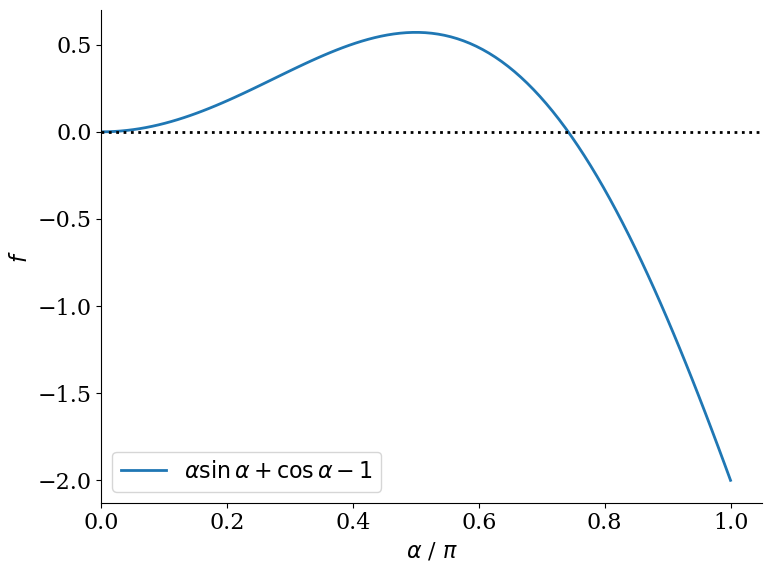

In [7]:
#HIDDEN
fig, ax = plt.subplots()
a_vals = np.linspace(0,np.pi,100)
ax.plot(a_vals/np.pi,f(a_vals),label='$\\alpha \\sin \\alpha + \\cos \\alpha - 1$')
ax.set_xlabel('$\\alpha$ / $\\pi$')
ax.set_ylabel('$f$')
ax.axhline(0,ls=':')
ax.set_xlim(left=0)
ax.legend();
fig.tight_layout();

Die Nullstelle bei $\alpha = 0$ ist praktisch irrelevant.

In [8]:
sol = scp.optimize.root(fun=f,x0=0.75*np.pi)

In [9]:
#HIDDEN
alpha = sol.x[0]
print("Der kritische Öffnungswinkel liegt bei %.2f°." %np.rad2deg(alpha))
h = 1/np.tan(alpha/2)
print("Der Gleitkreismittelpunkt liegt bei (0, %.3f b)." %h)
r = 1/np.sin(alpha/2)
print("Der Gleitkreisradius beträgt %.3f b." %r)

Der kritische Öffnungswinkel liegt bei 133.56°.
Der Gleitkreismittelpunkt liegt bei (0, 0.429 b).
Der Gleitkreisradius beträgt 1.088 b.


Die Last bei Grundbruch ergibt sich somit aus

$$
    \mu = 1 = \frac{p \sin^2 (\alpha/2)}{2c \alpha} \quad \rightarrow \quad p_\text{B} = 2 c \frac{\alpha}{\sin^2 (\alpha/2)}
$$

In [10]:
#HIDDEN
pB = 2 * alpha / np.sin(alpha/2)**2
print("Die Bruchlast beim Gleitkreis beträgt %.2f c." %pB)

Die Bruchlast beim Gleitkreis beträgt 5.52 c.


### Kinematische Variante 2: Zusammengesetzter Bruchmechanismus mit geraden Gleitlinien

Wir betrachten den dargestellten Bruchmechanismus, der geometrisch durch $b$ sowie $\vartheta_1$ und $\vartheta_2$ definiert ist.

**Aufgabe:** Begründen Sie anschaulich, warum die Gewichtskraft keine Rolle spielt (Hinweis: denken Sie an die Arbeit, die die Gewichtskraft im Gravitationsfeld verrichtet).

**Aufgabe:** Welche einschränkende Annahme versteckt sich in der Definition dieses Bruchmechanismus? Ist diese realistisch?

**Aufgabe:** Zeichnen Sie die Kräftepläne für die kinematischen Elemente für den kohäsiven, reibungs- und gewichtslosen Fall. Wiederholen Sie die Aufgabe für den gewichts- und reibungsbehafteten Fall.

Wir berechnen zunächst den angegebenen Fall für $\vartheta_1 = 45°$ und $\vartheta_2 = 57°$. Dafür erhalten wir eine Bruchlast von $p_\text{B} \approx 5.45 c$.

**Aufgabe:** Vollziehen Sie den rechnerisch einfachen Fall $\vartheta_1 = \vartheta_2 = 45°$ nach und zeigen Sie, dass $p_\text{B} = 6c$ gilt.

Bei einem Ausnutzungsgrad von 1.00 ergibt sich die Bruchlast zu 5.45 c


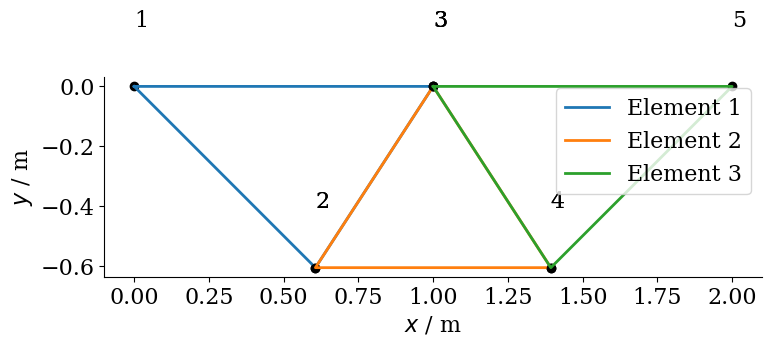

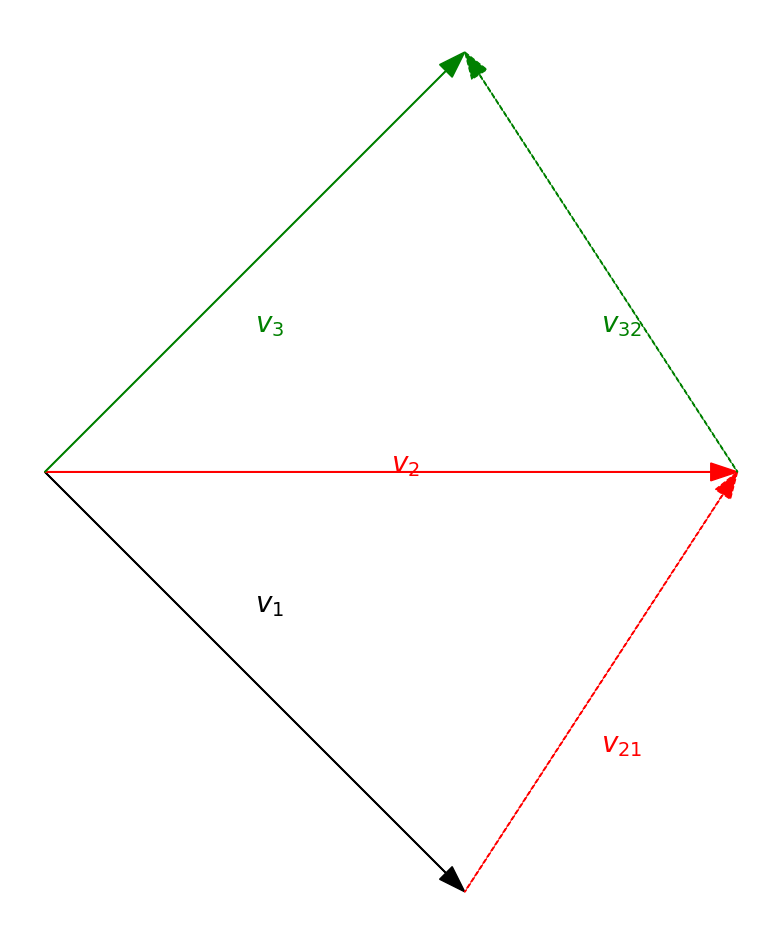

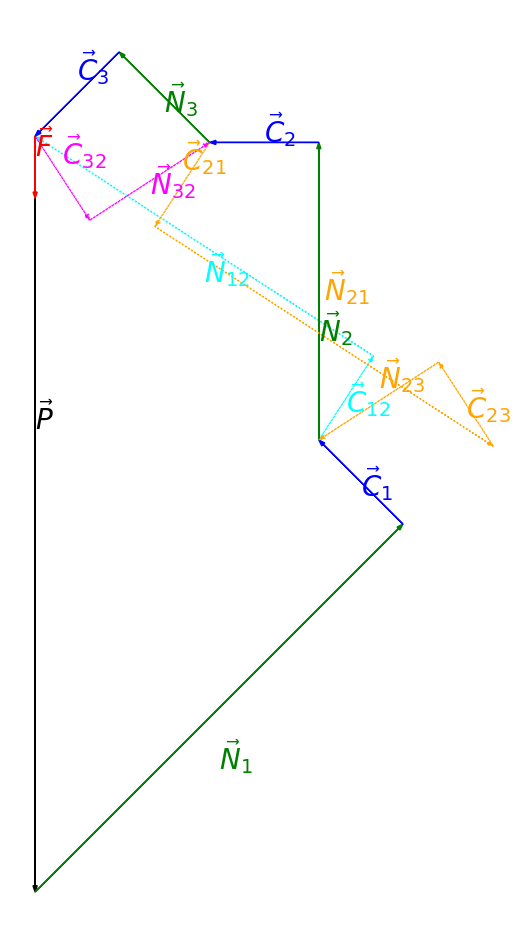

In [11]:
#HIDDEN
#%run plot_functions/KEM_plots.ipynb
#t1,t2,b,p,c,plot
additional = (45,57,1,5,1,True)
get_pB_GB([1.0],*additional);

Nun variieren wir die Winkel in folgenden Grenzen: $\vartheta_1 \in [25°,65°]$ und $\vartheta_2 \in [40°,80°]$ und untersuchen die Entwicklung der Bruchlast.

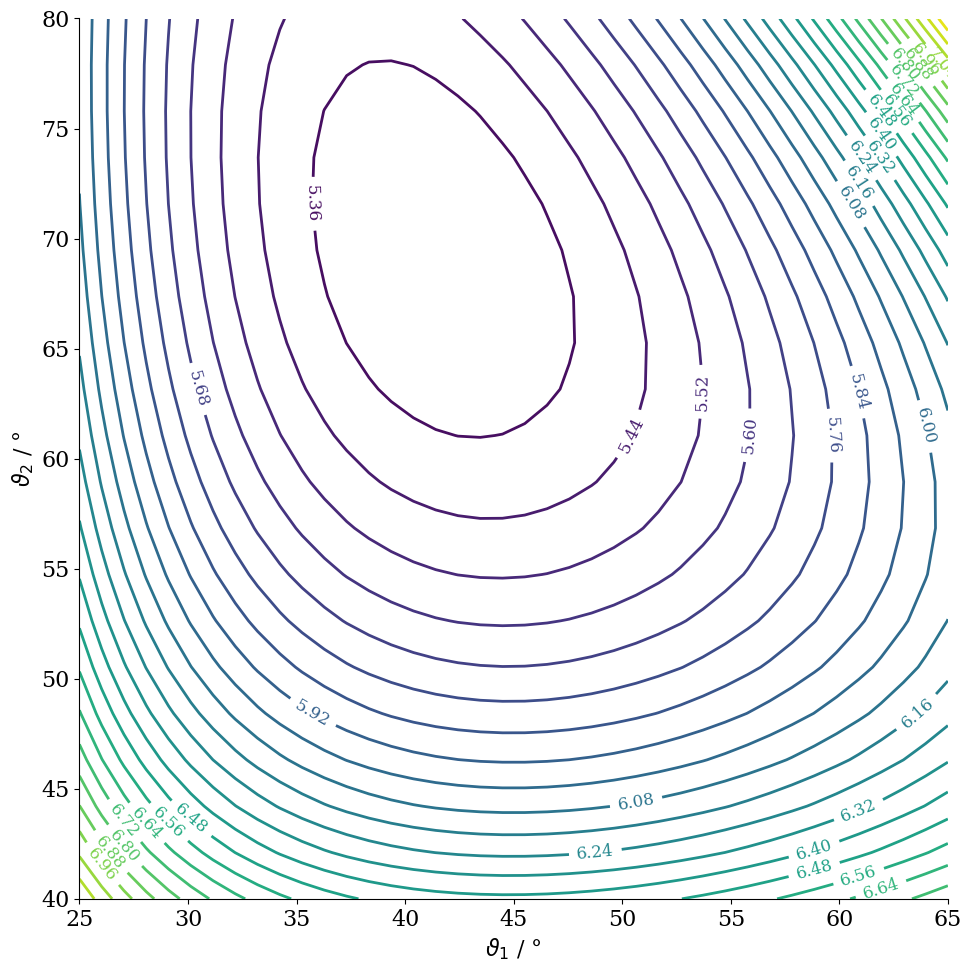

In [12]:
#HIDDEN
isoasphalien_GB()

Wir sehen die Lage des Optimums. Nun geben wir eine Verkehrslast von $p = 20$ kN/m² sowie eine Kohäsion von $c=5$ kN/m² und berechnen den maximalen Ausnutzungsgrad im oben dargestellten Feld.

In [13]:
#HIDDEN
#%run plot_functions/KEM_plots.ipynb
bounds = scp.optimize.Bounds([20,20],[80,80])
#bounds = scp.optimize.Bounds([np.deg2rad(45),np.deg2rad(57)],[np.deg2rad(45),np.deg2rad(57)])
var = (1,20,5,False)
res = scp.optimize.minimize(fun=optimize_mechanism_GB,x0=(45,57),args=var,bounds=bounds);
print("Der minimale Sicherheitsfaktor ist %.2f (entspricht einem Ausnutzungsgrad von %.2f) und tritt bei den Winkeln theta1 = %.2f° und theta2 = %.2f° auf." 
      %(res.fun,1/res.fun,res.x[0],res.x[1]))

Der minimale Sicherheitsfaktor ist 1.32 (entspricht einem Ausnutzungsgrad von 0.76) und tritt bei den Winkeln theta1 = 41.41° und theta2 = 69.30° auf.


Bei einem Ausnutzungsgrad von 1.00 ergibt sich die Bruchlast zu 5.29 c


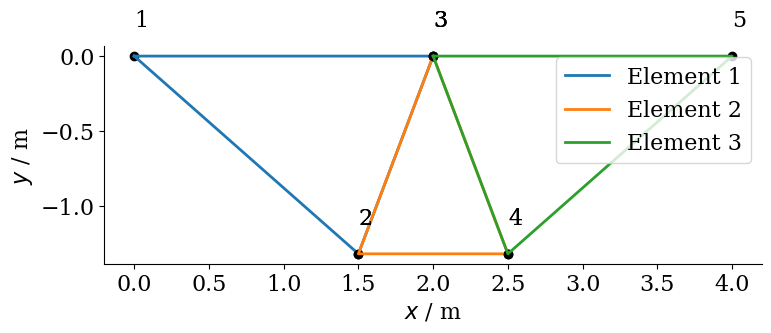

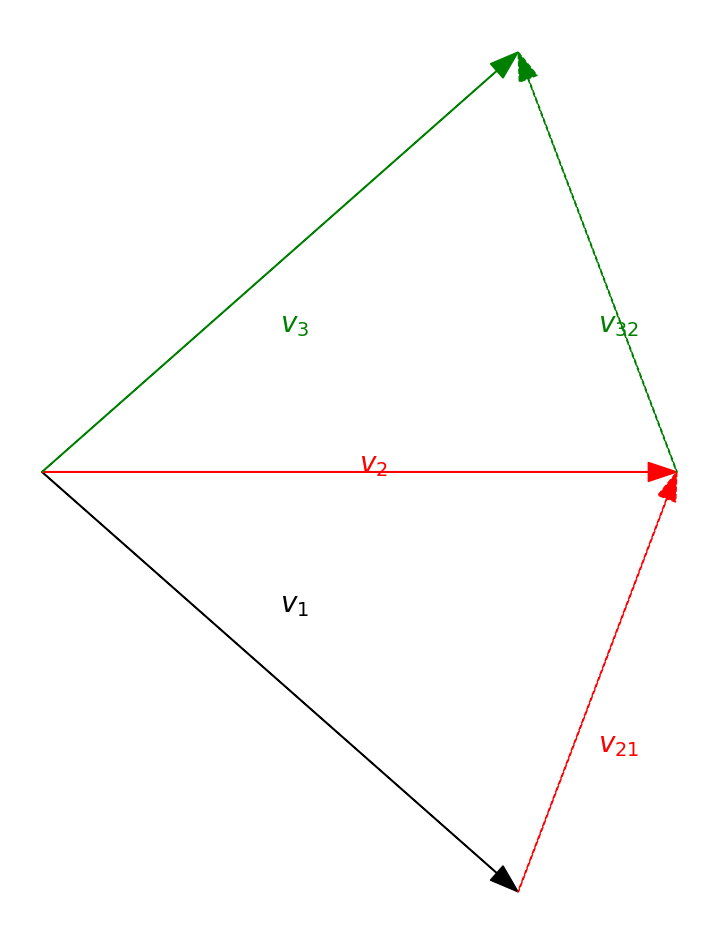

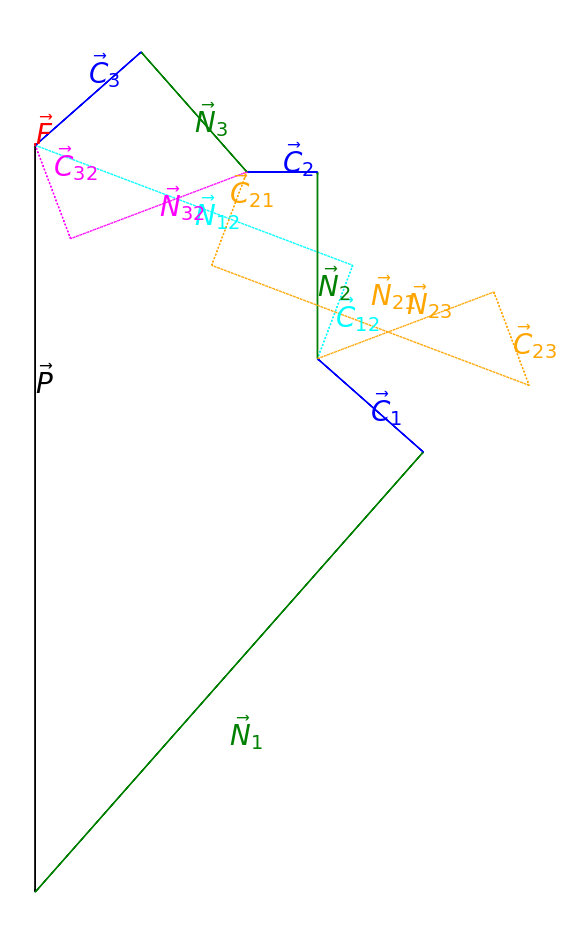

In [14]:
#HIDDEN
#%run plot_functions/KEM_plots.ipynb
#t1,t2,b,p,c,plot
additional = (res.x[0],res.x[1],2,10,1.89,True)
get_pB_GB([1.0],*additional);

Mithilfe der Schrankentheoreme können wir also basierend auf den bisher untersuchten Spannungsfeldern und Bruchkinematiken für den rein kohäsiven Boden einschränken:

$$
    p_\text{B} = N_{c0} c \quad \text{mit} \quad 5.14 \leq N_{c0} \leq 5.29
$$

Zudem lässt sich zeigen, dass der dreigliedrige Prandtl'schen Ansatz auch kinematisch zulässig ist. Somit Fallen untere und obere Schranke für diesen Fall zusammen und es gilt

$$
    N_{c0} = 2 + \pi \approx 5.14
$$